### Build & Train Model

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

*Import Data*

In [79]:
train_df = pd.read_csv('../data/train.csv')

*Clean Running Column*

In [80]:
def clean_running_column(df, column_name='running'):
    def convert(val):
        val = val.lower().replace(',', '').strip()
        if 'km' in val:
            return float(val.replace('km', '').strip())
        elif 'miles' in val:
            miles = float(val.replace('miles', '').strip())
            return round(miles * 1.60934, 2)
        return np.nan
    
    df['running_km'] = df[column_name].apply(convert)
    return df

*Calculate Car Age*

In [81]:
def add_car_age(df, year_col='year', current_year=2025):
    df['car_age'] = current_year - df[year_col].astype(int)
    return df

*Convert Motor Volume to Numeric Values*

In [82]:
def conver_to_numeric(df):
    df['motor_volume'] = pd.to_numeric(df['motor_volume'], errors='coerce')
    return df

*Encode Categories*

In [83]:
def encode_categoricals(df):
    label_encoders = {}

    categorical_cols = ['model', 'motor_type', 'wheel', 'color', 'type', 'status']

    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

    return df, label_encoders

*Process Training Dataset*

In [84]:
train_df = clean_running_column(train_df)
train_df = add_car_age(train_df)
train_df = conver_to_numeric(train_df)

train_df, encoders = encode_categoricals(train_df)

train_df.dropna(inplace=True)

*Train XGBoost Model*

In [85]:
features = ['model', 'motor_type', 'wheel', 'color', 'type', 'status', 'motor_volume', 'running_km', 'car_age']
target = 'price'

x_train = train_df[features]
y_train = train_df[target]

In [86]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],     # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1, 0.2], # Step size shrinkage
    'max_depth': [3, 5, 6, 8, 10],           # Maximum depth of a tree
    'subsample': [0.6, 0.8, 1.0],            # % of training instances used per tree
    'colsample_bytree': [0.6, 0.8, 1.0],     # % of features used per tree
    'gamma': [0, 0.1, 0.3, 0.5],             # Min loss reduction for a split
    'reg_lambda': [0.5, 1, 1.5, 2],          # L2 regularization
    'reg_alpha': [0, 0.1, 0.5, 1]            # L1 regularization
}

# 2. Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=param_grid,
    n_iter=30,                               # Try 30 random combinations
    scoring='neg_mean_squared_error',        # Optimize for MSE
    cv=5,                                    # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 3. Run the search
random_search.fit(x_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.6, 0.8, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], ...}"
,n_iter,30
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [87]:
model = XGBRegressor(
    **random_search.best_params_,
    objective='reg:squarederror',
    random_state=42
)

model.fit(x_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.6
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


*Process Test Dataset*

In [88]:
test_df = pd.read_csv('../data/test.csv')

test_df = clean_running_column(test_df)
test_df = add_car_age(test_df)
test_df = conver_to_numeric(test_df)

for col, le in encoders.items():
    if col in test_df.columns:
        test_df[col] = test_df[col].map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

*Predict Prices*

In [89]:
x_test = test_df[features]

predictions = model.predict(x_test)
rounded_preds = predictions.round().astype(int)

*Save .csv File*

In [90]:
output_df = pd.DataFrame({
    'Id': x_test.index,
    'price': rounded_preds
})

output_df.to_csv('../outputs/xgboost_predictions.csv', index=False)

### Evaluate XGBoost Model

*Split training data*

In [91]:
X = train_df[features]
y = train_df[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

*Train evaluation model*

In [92]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 6, 8, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_lambda': [0.5, 1, 1.5, 2],
    'reg_alpha': [0, 0.1, 0.5, 1]
}

random_search = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=param_grid,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.6, 0.8, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], ...}"
,n_iter,30
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [ ]:
evaluation_model = XGBRegressor(
    **random_search.best_params_,
    objective='reg:squarederror',
    random_state=42
)

evaluation_model.fit(
    X_train, y_train
)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.6
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [94]:
y_pred = evaluation_model.predict(X_val)

*Model Scores*

In [95]:
mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"📊 Mean Absolute Error (MAE):      {mae:.2f}")
print(f"📉 Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"📈 R² Score:                        {r2:.4f}")

📊 Mean Absolute Error (MAE):      2065.41
📉 Root Mean Squared Error (RMSE): 3446.91
📈 R² Score:                        0.7300


*Evaluation Graph*

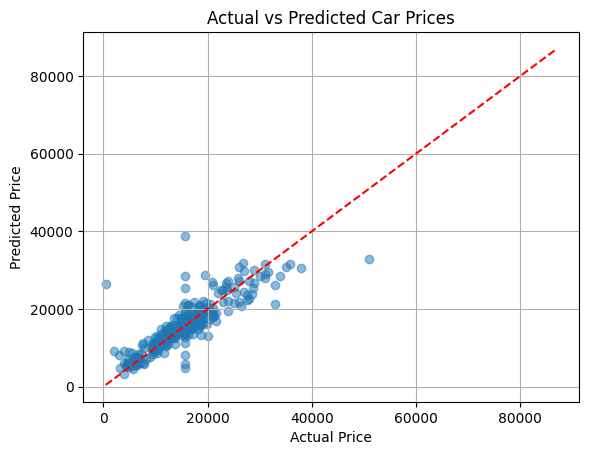

In [96]:
plt.scatter(y_val, y_pred, alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Prices")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.grid(True)
plt.show()

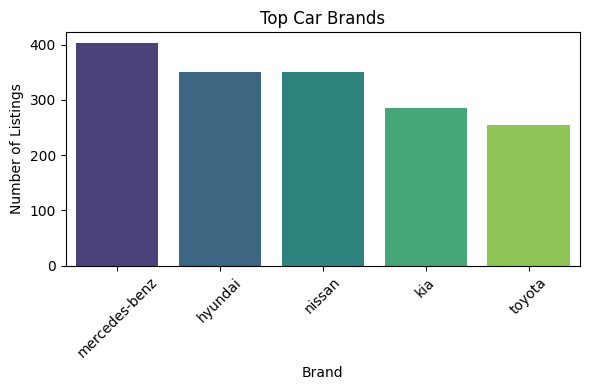

In [97]:
import joblib

encoders = joblib.load("../models/encoders.pkl")

model_encoder = encoders['model']

train_df['model_name'] = model_encoder.inverse_transform(train_df['model'])

plt.figure(figsize=(6, 4))
top_brands = train_df['model_name'].value_counts().head(10).reset_index()
top_brands.columns = ['model', 'count']

sns.barplot(data=top_brands, x='model', y='count', hue='model', palette="viridis", legend=False)
plt.title("Top Car Brands")
plt.ylabel("Number of Listings")
plt.xlabel("Brand")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

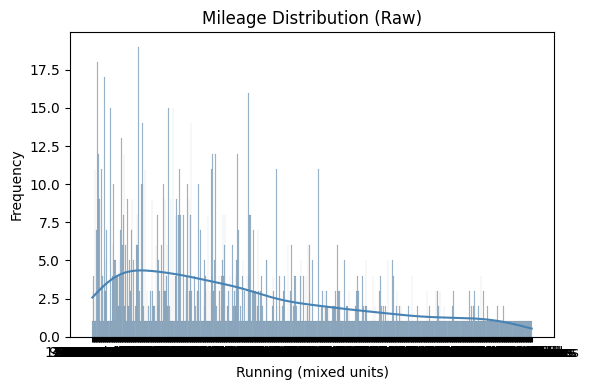

In [98]:
plt.figure(figsize=(6, 4))
sns.histplot(train_df['running'], bins=30, kde=True, color='steelblue')
plt.title("Mileage Distribution (Raw)")
plt.xlabel("Running (mixed units)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

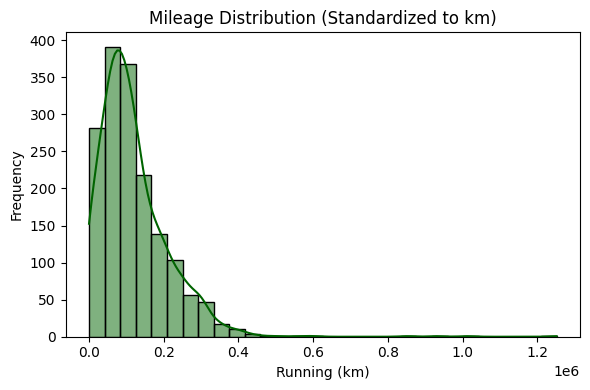

In [99]:
plt.figure(figsize=(6, 4))
sns.histplot(train_df['running_km'], bins=30, kde=True, color='darkgreen')
plt.title("Mileage Distribution (Standardized to km)")
plt.xlabel("Running (km)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

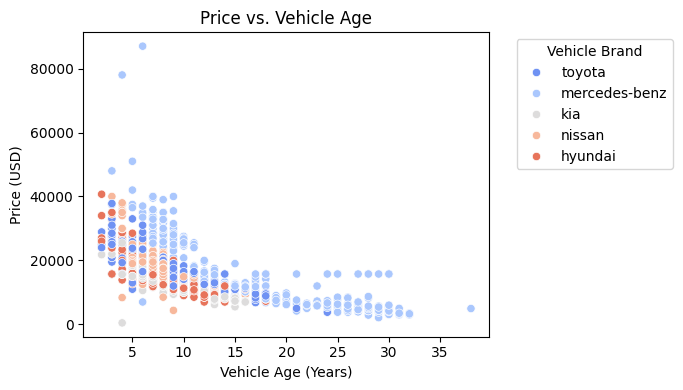

In [100]:
import joblib

encoders = joblib.load("../models/encoders.pkl")
model_encoder = encoders['model']

train_df['model_name'] = model_encoder.inverse_transform(train_df['model'])

plt.figure(figsize=(7, 4))
sns.scatterplot(
    data=train_df, 
    x='car_age', 
    y='price', 
    hue='model_name',
    palette='coolwarm'
)
plt.title("Price vs. Vehicle Age")
plt.xlabel("Vehicle Age (Years)")
plt.ylabel("Price (USD)")
plt.legend(title="Vehicle Brand", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

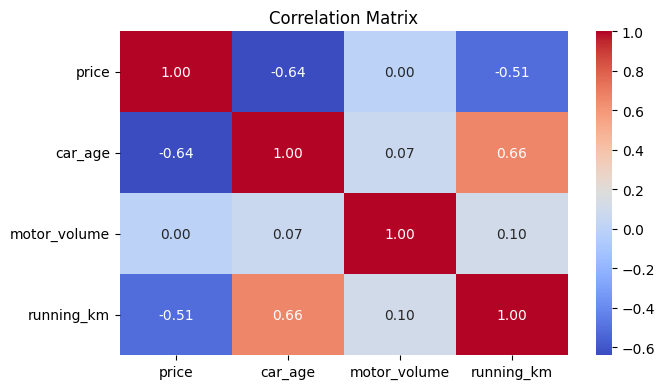

In [101]:
plt.figure(figsize=(7, 4))
corr = train_df[['price', 'car_age', 'motor_volume', 'running_km']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

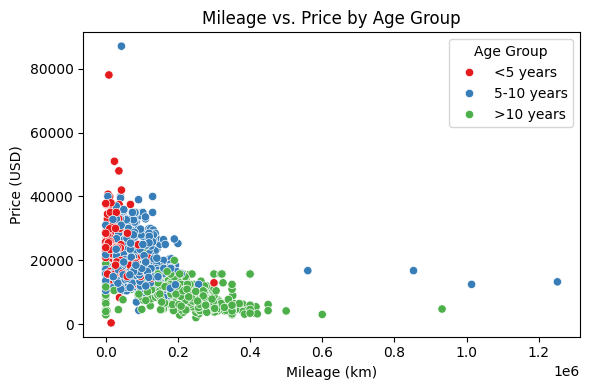

In [102]:
train_df['age_group'] = pd.cut(train_df['car_age'], bins=[0, 5, 10, 50], labels=['<5 years', '5-10 years', '>10 years'])

plt.figure(figsize=(6, 4))
sns.scatterplot(data=train_df, x='running_km', y='price', hue='age_group', palette='Set1')
plt.title("Mileage vs. Price by Age Group")
plt.xlabel("Mileage (km)")
plt.ylabel("Price (USD)")
plt.legend(title="Age Group")
plt.tight_layout()
plt.show()